In [21]:
import json
import numpy as np
import pandas as pd
import torch
from transformers import set_seed

import random
from tqdm import tqdm
from utils.plot_error_detection import plot_error_detection, plot_rejection_curve_aucs

## SST-2 results

Accuracy: 0.7867647058823529
0.7867647058823529
0.7843137254901961
0.7867647058823529
0.7843137254901961
0.7843137254901961
0.7892156862745098
0.7818627450980392
0.7867647058823529
0.7867647058823529
0.7867647058823529

bald: 0.6173595445268021
var_ratio: 0.5067855480359508
entropy: 0.5908260822859599
sampled_max_prob: 0.5908260822859599
variance: 0.6168224299065421
SNGP: 0.6579654098184553
max_prob: 0.6474200594406847


array([0.61735954, 0.50678555, 0.59082608, 0.59082608, 0.61682243,
       0.65796541, 0.64742006])

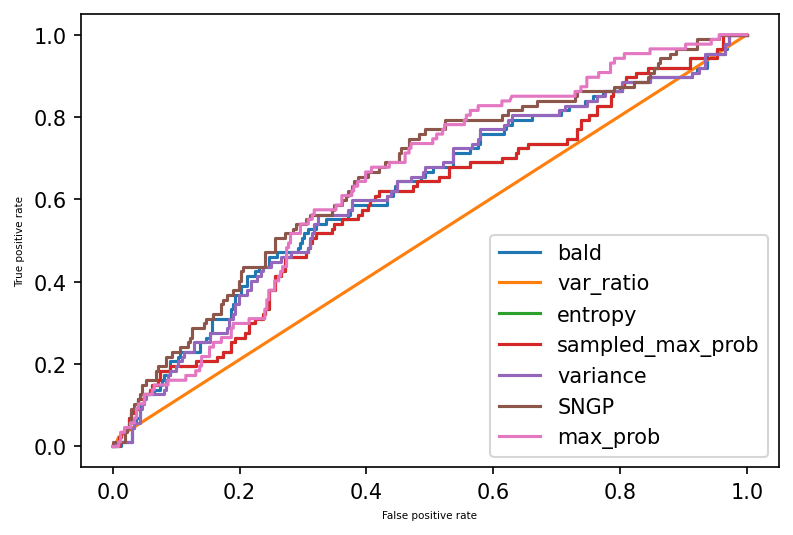

In [13]:
# prob_multiplier = 1.

path = '../workdir/results/mrpc/SNGP_last/0.0/2021-07-26/11-30-26-0/dev_inference.json'

with open(path) as f:
    model_outputs = json.load(f)
    
print('Accuracy:', (np.array(model_outputs['true_labels']) == np.array(model_outputs['answers'])).mean())

for sample in model_outputs['sampled_answers']:

    print((np.array(model_outputs['true_labels']) == sample).mean())
    
print()

plot_error_detection(np.asarray(model_outputs['probabilities']), 
                     np.asarray(model_outputs['true_labels']), 
                     np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                     stds=np.asarray(model_outputs['stds'])
                    )

bald: 0.8730392156862745
var_ratio: 0.8556985294117647
entropy: 0.8686274509803922
sampled_max_prob: 0.8686274509803922
variance: 0.8721200980392156
SNGP: 0.8791666666666667
max_prob: 0.8773897058823529


array([0.87303922, 0.85569853, 0.86862745, 0.86862745, 0.8721201 ,
       0.87916667, 0.87738971])

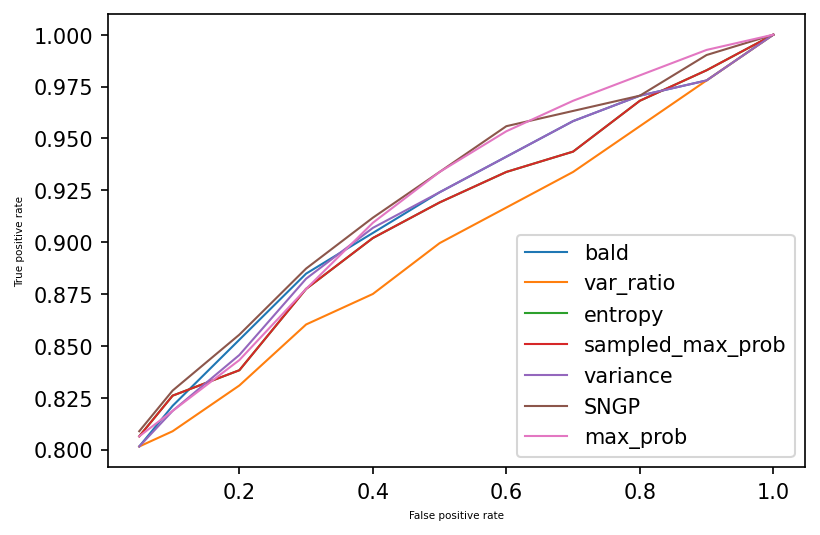

In [14]:
plot_rejection_curve_aucs(np.asarray(model_outputs['probabilities']), 
                          np.asarray(model_outputs['true_labels']), 
                          np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                          np.asarray(model_outputs['answers']),
                          stds=np.asarray(model_outputs['stds'])
                         )

## All results

In [6]:
iterables = [["accuracy", "AUC", "area under reject curve"], ["sst2", "cola", "mrpc"]]
index = pd.MultiIndex.from_product(iterables, names=["metric", "dataset"])
columns = ['baseline', 'SNGP', 'improvement over baseline']
res = pd.DataFrame(index=index, columns=columns)

for dataset in ["sst2", "cola", "mrpc"]:
    
    print(dataset)

    results_auc = []
    results_rejection = []
    acc = []
    method_names = ["bald", "var_ratio", "entropy", "sampled_max_prob", "variance", "use_stds", "max_prob"]

    for seed in [40, 41, 42]:

        with open(f'../../results/{dataset}_{seed}/dev_inference_electra.json') as f:
            model_outputs = json.load(f)

        acc.append((np.array(model_outputs['true_labels']) == np.array(model_outputs['answers'])).mean())
        print('Accuracy:', acc[-1])


#         for sample in model_outputs['sampled_answers']:

#             print((np.array(model_outputs['true_labels']) == sample).mean())

#         print()
        sngp_logits_adjusted = model_outputs['logits'] / np.sqrt(1. + (np.pi / 8.) * \
                                                                 np.square(model_outputs['stds']))
        sngp_probs = np.asarray(torch.nn.functional.softmax(torch.Tensor(sngp_logits_adjusted), dim=1))

        ue_scores = (1 - np.max(sngp_probs, axis=-1))
        stds = np.asarray(model_outputs['stds'])
#         stds = np.vstack([ue_scores, ue_scores]).T
        
        results_auc.append(plot_error_detection(np.asarray(model_outputs['probabilities']), 
                             np.asarray(model_outputs['true_labels']), 
                             np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                             stds=stds,
                             verbose=False
                            ))
        results_rejection.append(plot_rejection_curve_aucs(np.asarray(model_outputs['probabilities']), 
                              np.asarray(model_outputs['true_labels']), 
                              np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                              np.asarray(model_outputs['answers']),
                              stds=stds,
                              verbose=False
                             ))

    results_auc = np.array(results_auc) * 100
    results_rejection = np.array(results_rejection) * 100
    acc = np.array(acc) * 100

    for metric in ["AUC", "area under reject curve"]:
        if metric == "AUC":
            results = results_auc
        else:
            results = results_rejection

        res.loc[(metric, dataset)]['baseline'] = str(np.round(results.mean(axis=0)[-1], 2)) + '±' + \
                                                  str(np.round(results.std(axis=0)[-1], 2))
        res.loc[(metric, dataset)]['SNGP'] = str(np.round(results.mean(axis=0)[-2], 2)) + '±' + \
                                              str(np.round(results.std(axis=0)[-2], 2))
        res.loc[(metric, dataset)]['improvement over baseline'] = str(np.round((results[:, -2] - \
                                                                                 results[:, -1]).mean(), 2)) + '±' + \
                                            str(np.round((results[:, -2] - results[:, -1]).std(), 2))

    metric = "accuracy"
    res.loc[(metric, dataset)]['baseline'] = '-'
    res.loc[(metric, dataset)]['SNGP'] = str(np.round(acc.mean(), 2)) + '±' + \
                                         str(np.round(acc.std(), 2))
    res.loc[(metric, dataset)]['improvement over baseline'] = '-'

sst2
Accuracy: 0.9277522935779816
Accuracy: 0.9311926605504587
Accuracy: 0.9288990825688074
cola
Accuracy: 0.8513902205177373
Accuracy: 0.8418024928092043
Accuracy: 0.8456375838926175
mrpc
Accuracy: 0.8627450980392157
Accuracy: 0.8676470588235294
Accuracy: 0.875


In [7]:
res

baseline        SNGP  \
metric                  dataset                           
accuracy                sst2              -  92.93±0.14   
                        cola              -  84.63±0.39   
                        mrpc              -   86.85±0.5   
AUC                     sst2     79.51±1.72   81.1±3.02   
                        cola     68.77±1.33  70.81±0.71   
                        mrpc     72.56±0.61   71.56±2.0   
area under reject curve sst2       93.7±0.1  93.78±0.17   
                        cola     90.43±0.25  90.68±0.16   
                        mrpc     91.55±0.19  91.42±0.37   

                                improvement over baseline  
metric                  dataset                            
accuracy                sst2                            -  
                        cola                            -  
                        mrpc                            -  
AUC                     sst2                    1.59±2.12  
                        cola                    2.05±0.64  
                        mrpc                    -1.0±1.89  
area under reject curve sst2                    0.08±0.15  
                        cola                    0.25±0.09  
                        mrpc                   -0.12±0.29

# NUQ

In [22]:
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import ujson as json
import re

from ue4nlp.ue_scores import *
from ue4nlp.ue_variation_ratio import ue_variation_ratio

from utils.plot_error_detection import * 
from utils.plot_error_detection import draw_charts
from utils.plot_error_detection import create_chart_data

import matplotlib.pyplot as plt
from utils.plot_error_detection import plot_error_detection, plot_rejection_curve_aucs

In [23]:
methods = {
    "bald": bald,
    "var_ratio": var_ratio,
    "entropy": mean_entropy,
    "sampled_max_prob": sampled_max_prob,
    "variance": probability_variance,
}

NUQ epistemic: 0.6598601120429609
NUQ aleatoric: 0.6598932608479464
NUQ total: 0.6596612192130473


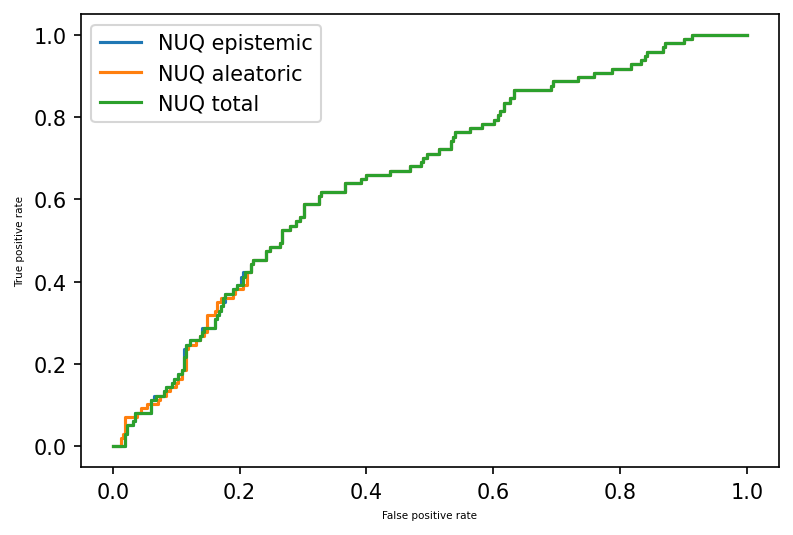

In [29]:
res_path = '../workdir/results/mrpc/MC_last/0.0/2021-07-29/14-44-50-rep0'

with open(Path(res_path) / 'dev_inference.json') as f:
    model_outputs = json.load(f)
    
plt.figure(dpi=150)

labels = np.asarray(model_outputs['out_of_scope_label'])
probas = np.asarray(model_outputs['predict_proba'])
errors = (labels!=probas.argmax(1)).astype('uint8')

for ue_col in ['epistemic','aleatoric', 'total']:
    ue_scores = np.asarray(model_outputs[ue_col])
    fpr, tpr, _ = roc_curve(errors, ue_scores)
    print(f"NUQ {ue_col}:", roc_auc_score(errors, ue_scores))
    plt.plot(fpr, tpr, label=f"NUQ {ue_col}")

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()

In [30]:
(labels==probas.argmax(1)).sum()/len(labels)

0.7622549019607843

In [31]:
from utils.plot_error_detection import *

NUQ epistemic: 0.8719362745098039
NUQ aleatoric: 0.8719975490196078
NUQ total: 0.8719362745098039


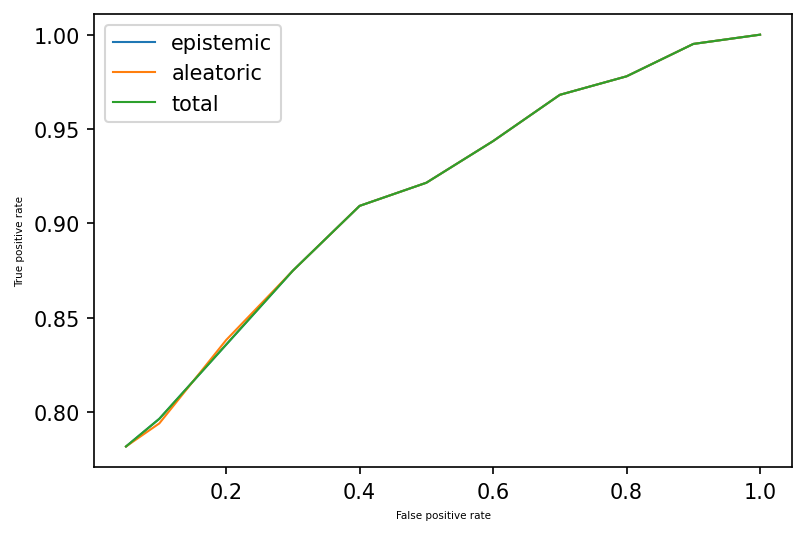

In [32]:
errors = (labels!=probas.argmax(1)).astype('uint8')

plt.figure(dpi=150)
aucs = []

ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for ue_col in ['epistemic','aleatoric', 'total']:
    ue_scores = np.asarray(model_outputs[ue_col])
    ensemble_answers = probas.argmax(1)
    sorted_indexes_ensemble = np.argsort(-ue_scores)
    ens_scores = [get_score_ratio(sorted_indexes_ensemble, ensemble_answers, labels, ratio) for ratio in ratio_list]

    plt.plot(ratio_list, ens_scores, label=ue_col, linewidth=1)
    print(f"NUQ {ue_col}:", auc(ratio_list, ens_scores))
    aucs.append(auc(ratio_list, ens_scores))

plt.ylabel("True positive rate", fontdict={"size": 5})
plt.xlabel("False positive rate", fontdict={"size": 5})
plt.legend()